<a href="https://colab.research.google.com/github/sobhanshukueian/Unsupervised-Learning/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %matplotlib inline
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
import shutil
import cv2
import glob
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 296

In [2]:
root_path = "./data"
# Download Dataset
labeled = datasets.STL10(root=root_path, split='train', download=True)
unlabeled = datasets.STL10(root=root_path, split='unlabeled', download=True)
test = datasets.STL10(root=root_path, split="test", download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])
val_transformation = transforms.Compose([transforms.Resize((96,96)), transforms.ToTensor()])

In [4]:
class STL10Unlabeld(Dataset):
    def __init__(self, transform, dataset):
        self.transform = transform
        self.dataset=dataset

        self.classes=['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck','unlabelled']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label=self.dataset[index]


        # img0 = Image.open(img)
        # img1 = Image.open(img)


        # img0 = img0.convert("L")
        # img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img)
            img1 = self.transform(img)
        

        return img0, img1, label

In [5]:
# Initialize the network
siamese_dataset = STL10Unlabeld(contrast_transforms, unlabeled)
siamese_testset = STL10Unlabeld(val_transformation, test)

In [6]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

# Load the testing dataset
test_dataloader = DataLoader(siamese_testset, shuffle=False, num_workers=2, batch_size=BATCH_SIZE)

In [7]:
train_features = next(iter(train_dataloader))
print(len(train_dataloader))
print("Train Images 1 Shape: {}\nTrain Images 2 Shape: {}\nTrain Data Labels Shape: {}".format(train_features[0].shape, train_features[1].shape, train_features[2].shape,))

test_features = next(iter(train_dataloader))
print(len(test_dataloader))
print("Test Images 1 Shape: {}\nTest Images 2 Shape: {}\nTest Data Labels Shape: {}".format(test_features[0].shape, test_features[1].shape, test_features[2].shape,))


338
Train Images 1 Shape: torch.Size([296, 3, 96, 96])
Train Images 2 Shape: torch.Size([296, 3, 96, 96])
Train Data Labels Shape: torch.Size([296])
28
Test Images 1 Shape: torch.Size([296, 3, 96, 96])
Test Images 2 Shape: torch.Size([296, 3, 96, 96])
Test Data Labels Shape: torch.Size([296])


In [8]:
# Showing images
def show_batch(data, cols = BATCH_SIZE):
    fig, ax = plt.subplots(2, cols, figsize=(cols*20, 2*20))
    for index in range(cols):
        ax[0, index].imshow(data[0][index].view(3, 96, 96).permute(1 , 2 , 0), interpolation='nearest')
        ax[1, index].imshow(data[1][index].view(3, 96, 96).permute(1 , 2 , 0), interpolation='nearest')
    plt.show()
    print(data[2].numpy().reshape(-1))

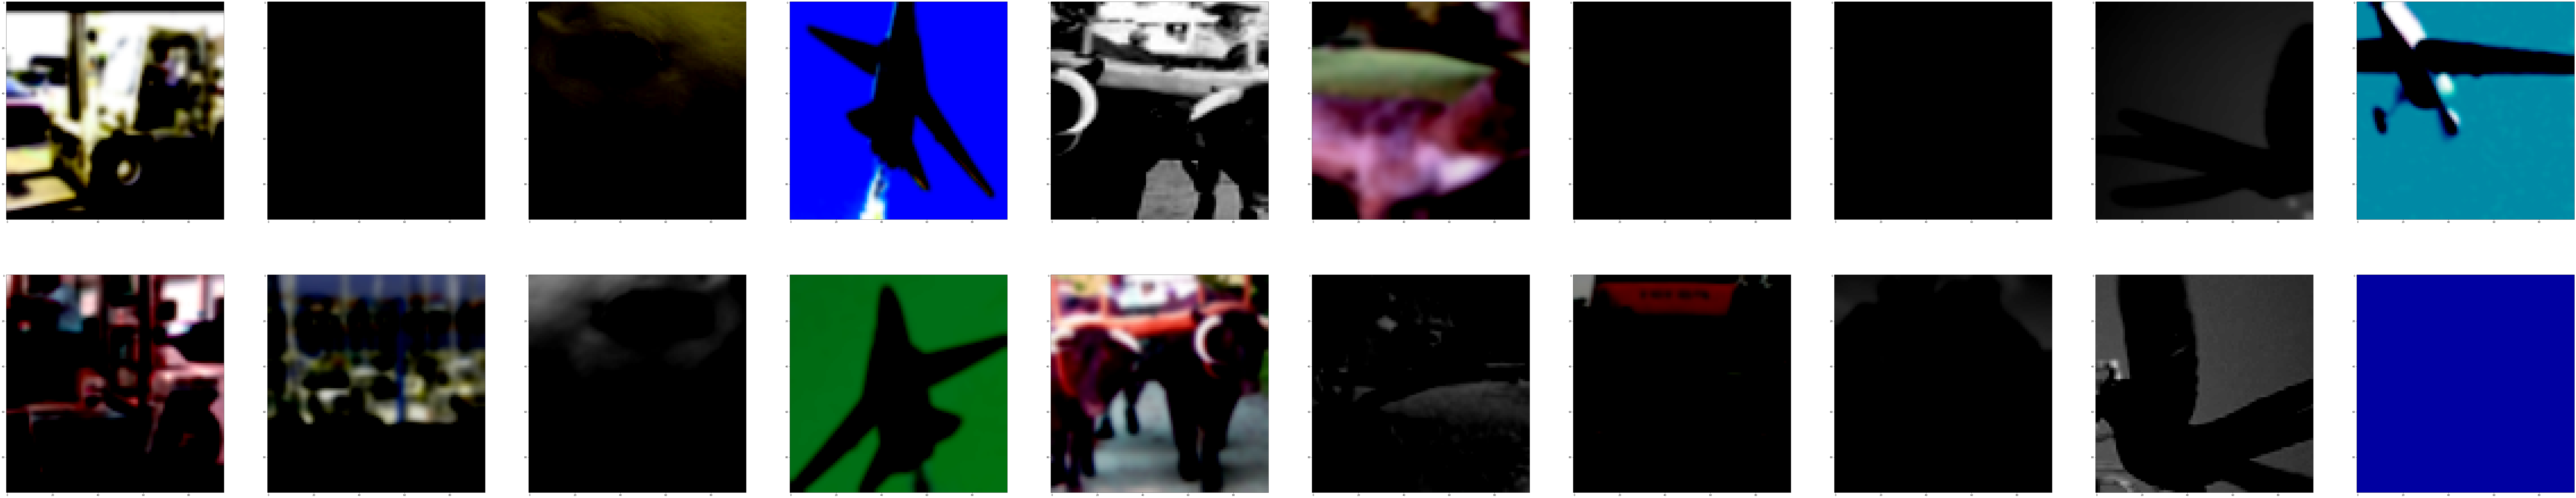

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [9]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=10)

# Extract one batch
example_batch = next(iter(vis_dataloader))
show_batch(example_batch, cols=10)

In [10]:
OUTPUT_EMBEDDING_SIZE = 264

#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.convnet = torchvision.models.resnet18(num_classes=4*OUTPUT_EMBEDDING_SIZE)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*OUTPUT_EMBEDDING_SIZE, OUTPUT_EMBEDDING_SIZE)
        )
    def forward(self, input1):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.convnet(input1)

        return output1



In [11]:
temp1 = torch.rand((6, 3, 96, 96))
temp_model = SiameseNetwork()
res = temp_model(temp1)
res.size()

torch.Size([6, 264])

In [12]:
# Define the InfoNCELoss Loss Function
class InfoNCELoss(torch.nn.Module):
    def __init__(self, margin=2):
        super(InfoNCELoss, self).__init__()
        self.margin = margin

    def forward(self, output1):
        cos_sim = F.cosine_similarity(output1[:,None,:], output1[None,:,:], dim=-1)
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        cos_sim = cos_sim #/ self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        return nll

In [13]:
def get_color(idx):
    return list(matplotlib.colors.cnames.keys())[idx]
  
def get_colors(idxs):
    res = []
    for idx in idxs:
      res.append(get_color(idx))
    return res 

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [15]:
import os
import time
import math
from copy import deepcopy
import os.path as osp
import shutil
from prettytable import PrettyTable
import json
from sklearn.metrics import auc

from tqdm import tqdm

import numpy as np
import torch
from torch.cuda import amp
# from torch.utils.tensorboard import SummaryWriter

class Trainer:
    # -----------------------------------------------INITIALIZE TRAINING-------------------------------------------------------------
    def __init__(self, device=device, epochs=10, batch_size=BATCH_SIZE, save_dir="./just_batch_runs", train_loader=train_dataloader, valid_loader=test_dataloader, weights=None, verbose=3, visualize_plots=True, save_plots=True):
        self.device = device
        self.save_dir = save_dir
        self.batch_size = batch_size
        self.epochs = epochs
        self.use_ema = False
        self.model_name = "AT&T Face Identification and Simple Siamese Architecture that end of the model apply batch Normalization Then scale it."
        self.weights = weights
        self.visualize_plots = visualize_plots
        self.save_plots = save_plots
        # 0 == nothing || 1 == model architecture || 2 == print optimizer || 3 == model parameters
        self.verbose = verbose
        self.train_losses=[]
        self.val_losses=[]
        self.conf = {'Name' : self.model_name, 'Bacth_size' : self.batch_size, 'Max_iter_num' : '', 'Epochs' : self.epochs, 'Trained_epoch' : 0, 'Optimizer' : '', "Model" : '', 'Parameter_size' : ''}

        temm=0
        tmp_save_dir = self.save_dir
        while osp.exists(tmp_save_dir):
            tmp_save_dir = self.save_dir
            temm+=1
            tmp_save_dir += (str(temm))
        self.save_dir = tmp_save_dir
        del temm


        # get data loader
        self.train_loader, self.valid_loader = train_loader, valid_loader
        self.max_stepnum = len(self.train_loader)
        self.conf["Max_iter_num"] = self.max_stepnum
        
        # get model 
        self.model = self.get_model()
        if self.verbose > 2:
            self.count_parameters()

        # Get optimizer
        self.optimizer = self.get_optimizer()
    
        # tensorboard
        # self.tblogger = SummaryWriter(self.save_dir) 

# ----------------------------------------------------INITIALIZERS-------------------------------------------------------------------------
    # Get Model 
    def get_model(self):
        # Get Model Archutecture From Model Class.
        model = SiameseNetwork().to(self.device)

        # finetune if pretrained model is set
        if self.weights:  
            print(f'Loading state_dict from {self.weights} for fine-tuning...')
            model.load_state_dict(torch.load(self.weights))
        # Log Model
        if self.verbose > 0:
            print('Model: {}'.format(model))
        self.conf["Model"] = str(model)
        return model

    def get_optimizer(self, optimizer="Adam", lr0=0.001, momentum=0.937):
        assert optimizer == 'SGD' or 'Adam', 'ERROR: unknown optimizer, use SGD defaulted'
        if optimizer == 'SGD':
            optim = torch.optim.SGD(self.model.parameters(), lr=lr0, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            optim = torch.optim.Adam(self.model.parameters(), lr=lr0, betas=(momentum, 0.999))

        if self.verbose > 1:
            print(f"{'optimizer:'} {type(optim).__name__}")
        self.conf['Optimizer'] = f"{'optimizer:'} {type(optim).__name__}"
        return optim

    # Loss Function Definition
    def compute_loss(self, output1):
        criterion = InfoNCELoss()
        loss = criterion(output1)
        return loss

    def count_parameters(self):
        table = PrettyTable(["Modules", "Parameters"])
        total_params = 0
        for name, parameter in self.model.named_parameters():
            if not parameter.requires_grad: continue
            params = parameter.numel()
            table.add_row([name, params])
            total_params+=params
        print(table)
        print(f"Total Trainable Params: {total_params}")
        self.conf["Parameter_size"] = total_params
# -------------------------------------------------------------------------------TRAINING PROCESS-----------------------------------------------
    @staticmethod
    def prepro_data(batch_data, device):
        images1 = batch_data[0].to(device)
        images2 = batch_data[1].to(device) 
        targets = batch_data[2].to(device)
        return images1, images2, targets

    # Each Train Step
    def train_step(self, batch_data):
        images1, images2, targets = self.prepro_data(batch_data, self.device)
        images = torch.cat([images1, images2], dim=0)
        # forward
        with amp.autocast(enabled=self.device != 'cpu'):
            preds = self.model(images)
            loss = self.compute_loss(preds)

        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())

        loss = loss + l2_lambda * l2_norm
        # backward
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        
        return loss.cpu().detach().numpy(), [pred.cpu().detach().numpy() for pred in preds], targets.cpu().detach().numpy()

    # Each Validation Step
    def val_step(self, batch_data):
        self.model.eval()
        images1, images2, targets = self.prepro_data(batch_data, self.device)
        images = torch.cat([images1, images2], dim=0)


        # forward
        preds = self.model(images)
        loss = self.compute_loss(preds)
        return loss.cpu().detach().numpy(), [pred.cpu().detach().numpy() for pred in preds], targets.cpu().detach().numpy()

    # Training Process
    def train(self):
        try:
            # training process prerequisite
            self.start_time = time.time()
            print('Start Training Process \nTime: {}'.format(time.ctime(self.start_time)))
            self.scaler = amp.GradScaler(enabled=self.device != 'cpu')
            self.best_loss = np.inf

            # Epoch Loop
            for self.epoch in range(0, self.epochs):
                try:
                    self.conf["Trained_epoch"] = self.epoch

                    # Training loop
                    self.model.train(True)
                    pbar = enumerate(self.train_loader)
                    pbar = tqdm(pbar, total=self.max_stepnum)
                    for step, batch_data in pbar:
                        self.train_loss, embeds, targets = self.train_step(batch_data)
                        self.train_losses.append(self.train_loss)
                        pbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Loss: {self.train_loss}  ")
                    del pbar

                    # # Train Validation Loop
                    # training1_embeddings = []
                    # training2_embeddings = []
                    # images1_classes = []
                    # images2_classes = []
                    # labels = []

                    # val_training1_embeddings = []
                    # val_training2_embeddings = []
                    # val_images1_classes = []
                    # val_images2_classes = []
                    # val_labels = []

                    # tbar = enumerate(self.train_loader)
                    # tbar = tqdm(tbar, total=self.max_stepnum)
                    # for step, batch_data in tbar:
                    #     self.train_val_loss, embeds, targets = self.val_step(batch_data)
                    #     tbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tTrain Validation Loss: {self.train_val_loss} ")
                    #     training1_embeddings.extend(embeds[0])
                    #     training2_embeddings.extend(embeds[1])
                    #     images1_classes.extend(images1_class)
                    #     images2_classes.extend(images2_class)
                    #     labels.extend(targets)
                    # del tbar

                    # # Validation Loop
                    # vbar = enumerate(self.valid_loader)
                    # vbar = tqdm(vbar, total=len(self.valid_loader))
                    # for step, batch_data in vbar:
                    #     self.val_loss, val_embeds, val_images1_class, val_images2_class, val_targets = self.val_step(batch_data)
                    #     self.val_losses.append(self.val_loss)
                    #     vbar.set_description(f"Epoch: {self.epoch}/{self.epochs}\tValidation Loss Loss: {self.val_loss}  ")
                    #     val_training1_embeddings.extend(val_embeds[0])
                    #     val_training2_embeddings.extend(val_embeds[1])
                    #     val_images1_classes.extend(val_images1_class)
                    #     val_images2_classes.extend(val_images2_class)
                    #     val_labels.extend(val_targets)
                    # del vbar

                    # # PLot Losses
                    # self.plot_loss()

                    # # calculate euclidean distances
                    # euclidean_distance = np.linalg.norm((np.array(training1_embeddings) - np.array(training2_embeddings)), axis=1)
                    # val_euclidean_distance = np.linalg.norm((np.array(val_training1_embeddings) - np.array(val_training2_embeddings)), axis=1)

                    # # Evaluate 
                    # # self.evaluation(euclidean_distance=euclidean_distance, labels=labels, title="Training")
                    # self.evaluation(euclidean_distance=val_euclidean_distance, labels=val_labels, title="Validation")

                    # # PLot Embeddings
                    # plot_size = BATCH_SIZE
                    # self.plot_embeddings(euclidean_distance, val_euclidean_distance, np.array(training1_embeddings), np.array(training2_embeddings), np.array(images1_classes), np.array(images2_classes), np.array(val_training1_embeddings), np.array(val_training2_embeddings), np.array(val_images1_classes), np.array(val_images2_classes), plot_size, plot_size)

                    # # Delete Data after PLotting
                    # del training1_embeddings, training2_embeddings, images1_classes, images2_classes, val_training1_embeddings, val_training2_embeddings, val_images1_classes, val_images2_classes
                    
                    # if self.val_loss < self.best_loss:
                    #     self.best_loss=self.val_loss

                except Exception as _:
                    print('ERROR in training steps.')
                    raise
                try:
                    self.save()
                except Exception as _:
                    print('ERROR in evaluate and save model.')
                    raise
        except Exception as _:
            print('ERROR in training loop or eval/save model.')
            raise
        finally:
            finish_time = time.time()
            print(f'\nTraining completed in {time.ctime(finish_time)} \nIts Done in: {(time.time() - self.start_time) / 3600:.3f} hours.') 
    

    # -------------------------------------------------------Training Callback after each epoch--------------------------
    def plot_loss(self, train_mean_size=1, val_mean_size=1):
        COLS=3
        ROWS=1
        LINE_WIDTH = 2
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle("Losses Plot", fontsize=16)

        # train_mean_size = self.max_stepnum/self.batch_size
        ax[0].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[0].set_title("Training Loss")

        val_mean_size = len(self.valid_loader)
        ax[1].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[1].set_title("Validation Loss")

        train_mean_size = self.max_stepnum
        ax[2].plot(np.arange(len(self.train_losses) / train_mean_size), np.mean(np.array(self.train_losses).reshape(-1, train_mean_size), axis=1), 'r',  label="training loss", linewidth=LINE_WIDTH)
        ax[2].plot(np.arange(len(self.val_losses) / val_mean_size), np.mean(np.array(self.val_losses).reshape(-1, val_mean_size), axis=1), 'g',  label="validation loss", linewidth=LINE_WIDTH)
        ax[2].set_title("Train Validation Loss")

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-loss-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def plot_embeddings(self, euclidean_distance, val_euclidean_distance, training1_embeddings, training2_embeddings, images1_classes, images2_classes, val_training1_embeddings, val_training2_embeddings, val_images1_classes, val_images2_classes, train_plot_size=0, val_plot_size=0):
        if train_plot_size > 0:
            training1_embeddings = np.array(training1_embeddings[:train_plot_size])
            training2_embeddings = np.array(training2_embeddings[:train_plot_size])
            images1_classes = np.array(images1_classes[:train_plot_size])
            images2_classes = np.array(images2_classes[:train_plot_size])
        if val_plot_size > 0:
            val_training1_embeddings = np.array(val_training1_embeddings[:val_plot_size])
            val_training2_embeddings = np.array(val_training2_embeddings[:val_plot_size])
            val_images1_classes = np.array(val_images1_classes[:val_plot_size])
            val_images2_classes = np.array(val_images2_classes[:val_plot_size])
        # print("Train embedding size : {} and val_training embedding size : {} image1_class size : {} image2_class size : {}".format(len(training1_embeddings), len(val_training1_embeddings), len(images1_classes), len(images2_classes)))
        # print(training1_embeddings, training1_embeddings[:, 0])

        COLS = 3
        ROWS = int(OUTPUT_EMBEDDING_SIZE / 2) + 1
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        # fig.suptitle("Embeddings Plot", fontsize=16)
        for dim in range(0, OUTPUT_EMBEDDING_SIZE, 2):
            ax[int(dim/2), 0].set_title("Training Embeddings for {} and {} dimensions".format(dim, dim+1))
            ax[int(dim/2), 0].scatter(training1_embeddings[:, dim], training1_embeddings[:, dim+1], c=get_colors(images1_classes))
            ax[int(dim/2), 0].scatter(training2_embeddings[:, dim], training2_embeddings[:, dim+1], c=get_colors(images2_classes))

            ax[int(dim/2), 1].set_title("Validation Embeddings for {} and {} dimensions".format(dim, dim+1))
            ax[int(dim/2), 1].scatter(val_training1_embeddings[:, dim], val_training1_embeddings[:, dim+1], c=get_colors(val_images1_classes))
            ax[int(dim/2), 1].scatter(val_training2_embeddings[:, dim], val_training2_embeddings[:, dim+1], c=get_colors(val_images2_classes))

            
            ax[int(dim/2), 2].set_title("Train Val for {} and {} dimensions".format(dim , dim+1))
            ax[int(dim/2), 2].scatter(training1_embeddings[:, dim], training1_embeddings[:, dim+1], c=get_colors(images1_classes))
            ax[int(dim/2), 2].scatter(training2_embeddings[:, dim], training2_embeddings[:, dim+1], c=get_colors(images2_classes))
            ax[int(dim/2), 2].scatter(val_training1_embeddings[:, dim], val_training1_embeddings[:, dim+1], c=get_colors(val_images1_classes))
            ax[int(dim/2), 2].scatter(val_training2_embeddings[:, dim], val_training2_embeddings[:, dim+1], c=get_colors(val_images2_classes))
    
        # Draw Rectangle
            rect_minx = min(np.min(val_training1_embeddings[:, dim]), np.min(val_training2_embeddings[:, dim]))
            rect_maxx = max(np.max(val_training1_embeddings[:, dim]), np.max(val_training2_embeddings[:, dim]))
            rect_miny = min(np.min(val_training1_embeddings[:, dim+1]), np.min(val_training2_embeddings[:, dim+1]))
            rect_maxy = max(np.max(val_training1_embeddings[:, dim+1]), np.max(val_training2_embeddings[:, dim+1]))
            rect=matplotlib.patches.Rectangle(xy=(rect_minx, rect_miny), width=rect_maxx-rect_minx, height=rect_maxy-rect_miny, linewidth=1, edgecolor='r', facecolor='none')
            ax[int(dim/2), 2].add_patch(rect)

        # Draw Histogram
        pos=[]
        neg=[]
        for index, label in enumerate(images1_classes):
            if label == images2_classes[index]:
                pos.append(euclidean_distance[index])
            elif label != images2_classes[index]:
                neg.append(euclidean_distance[index])

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].set_title("Training Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].hist(pos, bins = 15,  alpha = 0.5, lw=3, color='g', range=(0, np.max(euclidean_distance)))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 0].hist(neg, bins = 15,  alpha = 0.5, lw=3, color='r', range=(0, np.max(euclidean_distance)))

        val_pos=[]
        val_neg=[]
        for index, label in enumerate(val_images1_classes):
            if label == val_images2_classes[index]:
                val_pos.append(val_euclidean_distance[index])
            elif label != val_images2_classes[index]:
                val_neg.append(val_euclidean_distance[index])

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].set_title("Validation Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].hist(val_pos, bins = 15, alpha = 0.5, lw=3, color='g', range=(0, np.max(val_euclidean_distance)))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 1].hist(val_neg, bins = 15, alpha = 0.5, lw=3, color='r', range=(0, np.max(val_euclidean_distance)))

        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].set_title("Train Val Distances")
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].hist(np.concatenate([pos, val_pos]), bins = 15, alpha = 0.5, lw=3, color='g', range=(0, max(np.max(euclidean_distance), np.max(val_euclidean_distance))))
        ax[int(OUTPUT_EMBEDDING_SIZE / 2), 2].hist(np.concatenate([neg, val_neg]), bins = 15, alpha = 0.5, lw=3, color='r', range=(0, max(np.max(euclidean_distance), np.max(val_euclidean_distance))))

        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'plots') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()

    def evaluation(self, euclidean_distance, labels, title):
        true_pose_rate = []
        false_pose_rate = []
        precisions = []
        recalls = []
        f1_scores = []
        thresholds = []
        accs = []

        sorted_distances = np.sort(np.unique(euclidean_distance))

        for index, dis in enumerate(sorted_distances):
            if index == 0:
                threshold = -1.0
                thresholds.append(threshold)
            else:
                threshold = (dis + sorted_distances[index-1]) / 2.0
                thresholds.append(threshold)
            true_pos = 0
            false_pos = 0
            true_neg = 0
            false_neg = 0
            for i, label in enumerate(labels):
                if label == 0:
                    if euclidean_distance[i] < threshold:
                        true_pos += 1
                    else:
                        false_neg += 1
                elif label == 1:
                    if euclidean_distance[i] > threshold:
                        true_neg += 1
                    else:
                        false_pos += 1
            
            true_pose_rate.append(true_pos / (true_pos + false_neg))
            false_pose_rate.append(false_pos / (true_neg + false_pos))

            acc = (true_pos + true_neg) / (true_neg + false_neg + true_pos + false_pos)
            precision = 1 if true_pos + false_pos == 0 else true_pos / (true_pos + false_pos)
            recall = true_pos / (true_pos + false_neg)
            f1_score = 2 * (recall * precision) / (recall + precision  + 0.000001)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)
            accs.append(acc)

        # print(thresholds)
        # print(true_pose_rate)
        # print(false_pose_rate)

        # idx = np.argsort(np.array(false_pose_rate))
        # false_pose_rate = np.array(false_pose_rate)[idx]
        # true_pose_rate = np.array(true_pose_rate)[idx]
        roc_auc = auc(false_pose_rate, true_pose_rate)
        
        COLS = 3
        ROWS = 1
        fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS*10, ROWS*10))
        fig.suptitle(title, fontsize=16)
        ax[0].plot(false_pose_rate, true_pose_rate)
        ax[0].plot([0, 1])
        ax[0].set_xlabel('false positive')
        ax[0].set_ylabel('True positive')
        ax[0].set_title("ROC curve\nAUC: {}".format(roc_auc))
        # print("AUC: {}".format())

        ax[1].plot(precisions, recalls)
        ax[1].plot([0, 1])
        ax[1].set_xlabel('Precisions')
        ax[1].set_ylabel('Recalls')
        ax[1].set_title("Precision/Recall curve")
        # print("AUC : {}".format(self.calc_area(false_pose_rate, true_pose_rate)))


        ax[2].plot(thresholds, accs)
        ax[2].set_xlabel('Threshodls')
        ax[2].set_ylabel('Accuracies')
        ax[2].axvline(x=thresholds[np.argmax(accs)])
        ax[2].set_title("Accuracies/Threshodls\nMax: {}".format(thresholds[np.argmax(accs)]))
        if self.save_plots:
            save_plot_dir = osp.join(self.save_dir, 'evaluation') 
            if not osp.exists(save_plot_dir):
                os.makedirs(save_plot_dir)
            plt.savefig("{}/epoch-{}-plot.png".format(save_plot_dir, self.epoch)) 
        if self.visualize_plots:
            plt.show()
        return roc_auc
    
    # -------------------------------------------------------save Model-------------------------------------------
    def save(self):
        # create config object
        conf = json.dumps(self.conf)
        f = open(self.save_dir + "/config.json","w")
        f.write(conf)
        f.close()
        # save model
        save_ckpt_dir = osp.join(self.save_dir, 'weights')
        if not osp.exists(save_ckpt_dir):
            os.makedirs(save_ckpt_dir)
        filename = osp.join(save_ckpt_dir, self.model_name + "-" + str(self.epoch) + '.pt')
        torch.save(self.model.state_dict(), filename)
        if self.val_loss == self.best_loss:
            best_filename = osp.join(save_ckpt_dir, 'best_{}.pt'.format(self.model_name, self.epoch))
            if osp.exists(best_filename):
                os.remove(best_filename)
            shutil.copyfile(filename, best_filename)



Trainer(batch_size=BATCH_SIZE, device=device, epochs=100, verbose=10).train()
# Trainer(batch_size=32, device="cpu", epochs=50, verbose=0, weights="/content/runs/weights/best_SSL_epoch_45.pt").run("/content/data/faces/testing/s5/2.pgm", "/content/data/faces/testing/s7/4.pgm")

Model: SiameseNetwork(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

  0%|          | 0/338 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Epoch: 0/100	Train Loss: 19.29216766357422  :   0%|          | 1/338 [00:58<5:26:39, 58.16s/it]



Training completed in Thu Nov 17 19:24:27 2022 
Its Done in: 0.016 hours.


KeyboardInterrupt: ignored